In [4]:
import functools

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import interpolate, optimize
from scipy.misc import derivative

In [5]:
from sqlalchemy import create_engine  # connecting to local postgres database

engine = create_engine("postgresql://postgres@db/postgres")

raw_data = pd.read_sql_query(
    """
    SELECT 
        *, 
        date_trunc('day', datetime) as date,
        AVG("close") OVER(ORDER BY symbol, datetime ROWS BETWEEN 4 PRECEDING AND CURRENT ROW) AS close5
    FROM stocks_5m_rth 
    WHERE datetime > '2019-05-01' AND datetime < '2019-06-01'
    AND symbol IN ('TSLA', 'AMZN', 'CAR', 'GOOGL', 'AAPL', 'MSFT', 'BAC', 'BA', 'C', 'DB')
    ORDER BY datetime
    """,
    con=engine,
)

trading_days = raw_data.date.unique()
trading_symbols = raw_data.symbol.unique()

print(trading_symbols)
# print(trading_days)

['C' 'BA' 'MSFT' 'TSLA' 'AAPL' 'CAR' 'DB' 'GOOGL' 'BAC' 'AMZN']


In [6]:
def getmydata(myday, mysymbol):
    ts_data = raw_data[(raw_data["date"] == myday) & (raw_data["symbol"] == mysymbol)]
    ts_data = ts_data.reset_index(
        drop=True
    )  # This changes the index to a contiguous range starting from 0
    return ts_data


# test this function --> success
# getmydata("2020-01-21", "AAPL")
# ts_price = getmydata("2020-01-21", "AAPL")
myday = "2019-05-20"
mysymbol = "AAPL"
ts_price = getmydata(myday, mysymbol)
ts_price

,symbol,datetime,open,high,low,close,volume,date,close5
0,AAPL,2019-05-20 09:30:00,183.630,183.99,181.3100,181.3670,2661163.0,2019-05-20,187.42348
1,AAPL,2019-05-20 09:35:00,181.360,181.39,180.2839,181.2600,1904850.0,2019-05-20,185.87748
2,AAPL,2019-05-20 09:40:00,181.245,181.90,180.6900,181.8032,1030681.0,2019-05-20,184.49604
3,AAPL,2019-05-20 09:45:00,181.800,183.49,181.6300,183.1700,1187377.0,2019-05-20,183.31604
4,AAPL,2019-05-20 09:50:00,183.140,183.18,181.8900,182.5800,874099.0,2019-05-20,182.03604
...,...,...,...,...,...,...,...,...,...
73,AAPL,2019-05-20 15:35:00,182.870,183.15,182.8400,183.0800,392076.0,2019-05-20,182.79096
74,AAPL,2019-05-20 15:40:00,183.090,183.17,182.8300,182.8600,335324.0,2019-05-20,182.84096
75,AAPL,2019-05-20 15:45:00,182.860,183.05,182.7000,182.7700,418184.0,2019-05-20,182.88800
76,AAPL,2019-05-20 15:50:00,182.775,183.14,182.7750,183.0900,439551.0,2019-05-20,182.93800


In [7]:
def graph(myday, mysymbol, timeframe):

    ts_price = getmydata(myday, mysymbol)
    now = timeframe
    x = np.linspace(0, now + 19, num=now + 20, endpoint=True)
    y = ts_price["close"]
    ysmooth5 = ts_price["close5"]

    def test_func_affine(x, m, k):
        return m * x + k

    def test_func_sin(x, a, b, c):
        return a * np.sin(b * x + c)

    def test_func_wave(x, a, b, c, d):
        return a * np.sin(b * x + c) + d

    affineparams, affineparams_covariance = optimize.curve_fit(
        test_func_affine,
        x[now - 10 : now],
        ysmooth5[now - 10 : now],
        p0=[0, ysmooth5[now - 5]],
    )

    yresidual5 = ysmooth5[now - 20 : now] - test_func_affine(
        x[now - 20 : now], affineparams[0], affineparams[1]
    )

    residualparams, residualparams_covariance = optimize.curve_fit(
        test_func_wave,
        x[now - 15 : now],
        yresidual5.tail(15),
        p0=[0.1, 0.05, 1, 0],
        maxfev=100000,
    )

    def fitted_curve(x):
        function1 = test_func_affine(x + 3, affineparams[0], affineparams[1])
        function2 = test_func_wave(
            x + 3,
            residualparams[0],
            residualparams[1],
            residualparams[2],
            residualparams[3],
        )
        return function1 + function2

    xaffine = np.linspace(now - 15, now + 5, num=200, endpoint=True)
    xresidual = np.linspace(now - 15, now + 5, num=200, endpoint=True)
    yaffine = test_func_affine(xaffine + 2, affineparams[0], affineparams[1])
    yresidual = fitted_curve(xresidual)
    thisfigure = plt.figure()

    plt.plot(
        x[now - 21 : now + 10],
        y[now - 21 : now + 10],
        "b",
        xresidual,
        yresidual,
        "r",
        xaffine,
        yaffine,
        "g",
        x[now - 21 : now + 10],
        ysmooth5[now - 21 : now + 10],
        "y",
    )
    plt.axvline(now, linewidth=2, color="black", linestyle="--")
    plt.legend(["Points", "Fitted", "Affine"])
    plt.title(f"Sine Plot {timeframe} Date {myday}")
    plt.show()

/opt/conda/lib/python3.9/site-packages/scipy/optimize/minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


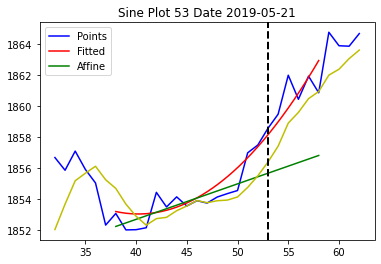

In [67]:
myday = "2019-05-21"
mysymbol = "AMZN"
graph(myday, mysymbol, 53)

In [36]:
def buyorsell(myday, mysmbol, timeframe):

    ts_price = getmydata(myday, mysymbol)

    if timeframe < 20:
        return 0

    try:
        now = timeframe
        x = np.linspace(0, now + 19, num=now + 20, endpoint=True)
        y = ts_price["close"]
        # ysmooth10 = ts_price["close10"]
        ysmooth5 = ts_price["close5"]

        def test_func_affine(x, m, k):
            return m * x + k

        def test_func_sin(x, a, b, c):
            return a * np.sin(b * x + c)

        def test_func_wave(x, a, b, c, d):
            return a * np.sin(b * x + c) + d

        # def test_func(x, a, b, c, d, m, k):
        #   return m * x + k + a * np.sin(b * x + c) + d

        affineparams, affineparams_covariance = optimize.curve_fit(
            test_func_affine,
            x[now - 15 : now],
            ysmooth5[now - 15 : now],
            p0=[0, ysmooth5[now - 5]],
        )

        yresidual5 = ysmooth5[now - 20 : now] - test_func_affine(
            x[now - 20 : now], affineparams[0], affineparams[1]
        )

        residualparams, residualparams_covariance = optimize.curve_fit(
            test_func_wave,
            x[now - 15 : now],
            yresidual5.tail(15),
            p0=[0.1, 0.05, 1, 0],
            maxfev=100000,
        )

        def fitted_curve(x):
            function1 = test_func_affine(x + 2, affineparams[0], affineparams[1])
            function2 = test_func_wave(
                x + 2,
                residualparams[0],
                residualparams[1],
                residualparams[2],
                residualparams[3],
            )
            return function1 + function2

        def first_derivative(x):
            return derivative(fitted_curve, x, dx=1e-3)

        def second_derivative(x):
            return derivative(first_derivative, x, dx=1e-3)

        # print (timeframe, first_derivative(timeframe), second_derivative(timeframe), 0.3*(affineparams[0] + residualparams[0]*residualparams[1]))
        # print (affineparams[0], residualparams[0], residualparams[1])

        def goodfit(ff, realvalues, x, dx):
            memo = 0
            measure = map(
                lambda point: ((ff(point) - realvalues[point]) ** 2), x[now - 20 : now]
            )
            for result in measure:
                memo = memo + result * dx
            return memo / (ysmooth5[now] ** 2)

        print("Goodness of fit:")
        print(goodfit(fitted_curve, y, x, 5))

        # If trend is strong, then go with the flow.
        if (affineparams[0]) > ysmooth5[now] * 0.001:
            print("Buying trend")
            return 1
        if (affineparams[0]) < ysmooth5[now] * -0.001:
            print("Selling trend")
            return -1

        if (goodfit(fitted_curve, y, x)) > 1e-04:
            print("Fit not good enough")
            return 0
        else:
            print("Good fit")

        # stop trading at the end of day if none of the above
        if timeframe > 60:
            return 0

        fd = first_derivative(timeframe)
        sd = second_derivative(timeframe)

        if sd > 0:
            return 1
        if sd < 0:
            return -1
        else:
            return 0

    except:
        return "exception occured"

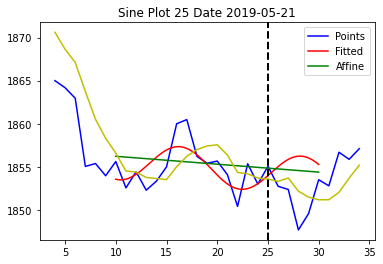

Goodness of fit:
0.00021641951138914864
Fit not good enough


0

In [76]:
myday = "2019-05-21"
mysymbol = "AMZN"
timeframe = 25

graph(myday, mysymbol, timeframe)
buyorsell(myday, mysymbol, timeframe)

In [ ]:
def tradeonedayonesymbolwithgraph(myday, mysymbol):
    ts_price = getmydata(myday, mysymbol)
    for timeframe in [*range(len(ts_price))]:
        print(timeframe, buyorsell(myday, mysymbol, timeframe))
        if timeframe > 19:
            graph(myday, mysymbol, timeframe)
    return "Done"

In [ ]:
myday = "2019-05-22"
mysymbol = "GOOGL"
tradeonedayonesymbolwithgraph(myday, mysymbol)

In [56]:
# simulation


def tradeonedayonesymbol(myday, mysymbol):
    ts_price = getmydata(myday, mysymbol)
    prices = []
    cash = 0
    pos = 0
    first_price = ts_price["open"][1]
    for timeframe in [*range(len(ts_price))]:
        #        print(myday, mysymbol, timeframe)
        bs = buyorsell(myday, mysymbol, timeframe)
        price = ts_price["close"][timeframe]

        if bs == 1:
            cash = cash - price
            pos = pos + 1
        if bs == -1:
            cash = cash + price
            pos = pos - 1

        print(timeframe, pos, price, cash, cash + pos * price)

        # if timeframe > 19:
        #    if timeframe < 65:
        #       graph(myday, mysymbol, timeframe)
        # print(
        #   timeframe,
        #  pos,
        # price,
        # (cash),
        # (cash + pos * price),
        # )
    last_price = ts_price["close"].values[-1]
    cash = cash + pos * last_price
    prices.append(pos * last_price)
    pos = 0
    print("Daily Position", pos, last_price, cash)
    print(100 * cash / last_price)
    return round(100 * cash / first_price, 2)


def tradealldaysonesymbol(daylist, symbol):
    profit = 0
    print(symbol)
    for day in daylist:
        daily_profit = tradeonedayonesymbol(day, symbol)
        profit = profit + daily_profit
        # print(day, " Daily: ", int(daily_profit), " Total to Date: ", int(profit))
    return profit


def tradeonedayallsymbols(day, symbollist):
    profit = 0
    print(day)
    for symbol in symbollist:
        symbol_profit = tradeonedayonesymbol(day, symbol)
        profit = profit + symbol_profit
        print(symbol, " Symbol Profit: ", int(symbol_profit), " Total: ", int(profit))
    return profit


def simulate(daylist, symbollist):
    overallprofit = 0
    for symbol in symbollist:
        symbol_profit = tradealldaysonesymbol(daylist, symbol)
        overallprofit = overallprofit + symbol_profit
        print(
            symbol,
            " Symbol Profit: ",
            int(symbol_profit),
            " Overall Profit: ",
            int(overallprofit),
        )
    return overallprofit

In [58]:
myday = "2019-05-28"
mysymbol = "AMZN"
tradeonedayonesymbol(myday, mysymbol)

0 0 1834.8812 0 0.0
1 0 1839.15 0 0.0
2 0 1840.21 0 0.0
3 0 1842.8632 0 0.0
4 0 1845.5328 0 0.0
5 0 1841.96 0 0.0
6 0 1842.945 0 0.0
7 0 1840.98 0 0.0
8 0 1840.5674 0 0.0
9 0 1838.6818 0 0.0
10 0 1838.0644 0 0.0
11 0 1837.77 0 0.0
12 0 1835.57 0 0.0
13 0 1834.5736 0 0.0
14 0 1838.6 0 0.0
15 0 1838.0 0 0.0
16 0 1836.8278 0 0.0
17 0 1839.316 0 0.0
18 0 1841.7324 0 0.0
19 0 1843.38 0 0.0
2.227695525290916e-05
Fit not good enough
20 0 1844.6354 0 0.0
7.082475352572414e-05
Fit not good enough
21 0 1843.67 0 0.0
2.6679991279839107e-05
Fit not good enough
22 0 1842.5 0 0.0
0.00017777957641387955
Fit not good enough
23 0 1839.68 0 0.0
0.00018454184034232744
Fit not good enough
24 0 1839.78 0 0.0
0.000133749511334519
Fit not good enough
25 0 1842.415 0 0.0
6.498565957981508e-05
Fit not good enough
26 0 1844.45 0 0.0
1.7324435617487763e-05
27 -1 1844.4542 1844.4542 0.0
2.2132292023314988e-05
Fit not good enough
28 -1 1842.019 1844.4542 2.4351999999998952
2.6434412639611402e-05
Fit not good enoug

0.37